# Lib import

In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import torch
import torch.optim as optim 
from torch import nn
from torch.optim import lr_scheduler

# Method 

In [2]:
# GAN noise data generation method

def noise(n, n_features=128):
    """
    128차원의 노이즈 데이터 생성
    """
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    """
    진짜 데이터 레이블 생성
    """
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    """
    가짜 데이터 레이블 생성
    """
    data = torch.zeros(size,1)
    return data.to(device)

In [3]:
# Discriminator train method
def train_discriminator(optimizer, real_data, fake_data):
    """
    real_data : batch_item
    """
    n = real_data.size(0)
    optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))

    loss = d_loss + g_loss
    loss.backward()
    optimizer.step()

    return loss.item()

In [4]:
# Generator train method 
def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    loss.backward()
    optimizer.step()
    return loss.item()

# GAN model

In [5]:
"""
MLP를 활용하여 Simple한 GAN 모델을 정의한다. 
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.n_out),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.linear(x)
        return output


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784 
        self.n_out = 1
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, self.n_out),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        x = self.linear(x)
        return x 

# 차원 축소된 훈련데이터 로드 

In [6]:
"""
앞서  baseline을 통해 가장 성능이 좋은 모델의 
CNN Encoder와 RNN Encoder 를 통해 train data를 차원축소하게된다

그 이유는 GAN 의 input으로 784차원의 데이터를 입력으로 넣어야 하고, 
실제 원본 데이터를 CNN_Encoder와 RNN_Encoder concat한 데이터를 real data로 활용하게된다.
"""

par_dir = "./pca_data"
with open(os.path.join(par_dir, "pca_output.pickle"), 'rb') as f:
    pca_output = pickle.load(f)
with open(os.path.join(par_dir, "pca_label.pickle"), 'rb') as f:
    pca_label = pickle.load(f)

# Script

In [7]:
# 모델 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

criterion = nn.BCELoss().to(device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=g_optim, mode='min', verbose=True, patience=10, factor=0.5)

In [8]:
# GAN 훈련 
trainloader = torch.utils.data.DataLoader(pca_output, batch_size=64, num_workers=4, shuffle=False)

epochs = 10

g_losses = []
d_losses = []
new_data = []

test_noise = noise(830)
l = len(trainloader)

for epoch in range(epochs):
    g_loss = 0.0
    d_loss = 0.0
    
    for data in trainloader:
        
        n = len(data)
        input = data.to(device)

        fake_data = generator(noise(n)).detach().to(device)

        d_loss += train_discriminator(d_optim, input, fake_data) # batch_item을 넣어주자 
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)

    scheduler.step(g_loss / l)

    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)
    if epoch % 10 == 0:
        print("Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r".format(epoch, g_loss/l, d_loss/l))

torch.save(discriminator.state_dict(), f"./model_save/discriminator.pt")
torch.save(generator.state_dict(), f"./model_save/generator.pt")

Epoch 0: g_loss: 0.610 d_loss: 0.986


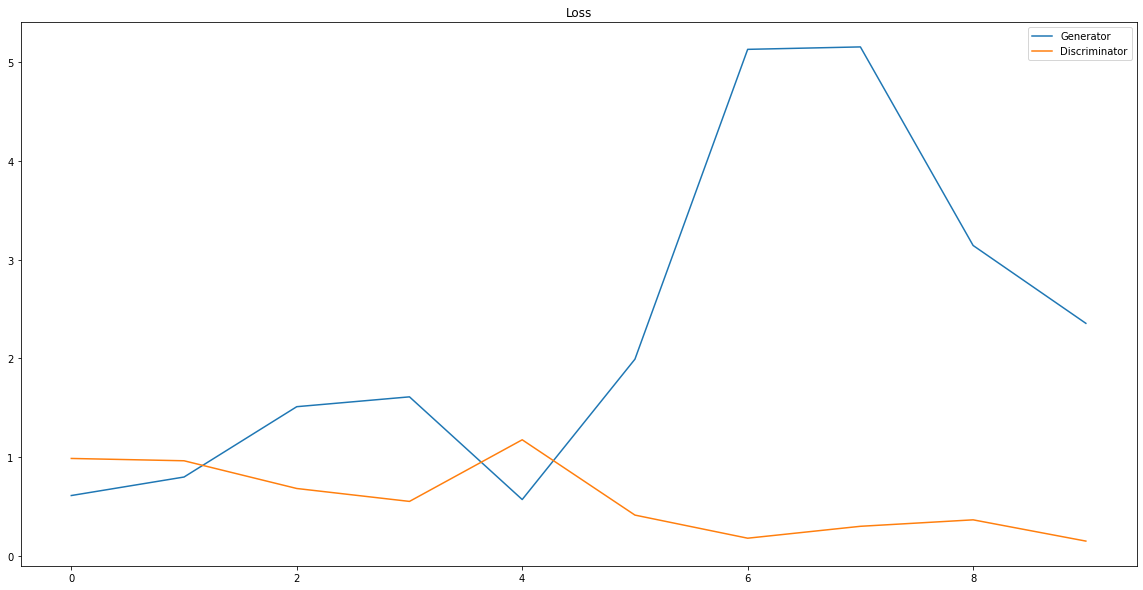

In [9]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(["Generator", "Discriminator"])
plt.title("Loss")
plt.show()

# GAN data generation

In [10]:
# GAN 모델을 통해 data 생성을 위해 
# 훈련된 GAN 모델 불러옴

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.load_state_dict(torch.load("./model_save/generator.pt"))
discriminator.load_state_dict(torch.load("./model_save/discriminator.pt"))

<All keys matched successfully>

In [11]:
"""
데이터 생성을 위애 1에포크만 진행 
차원 축소된 train data와 같은 양의 데이터 생성 

"""

epochs = 1

g_losses = []
d_losses = []

new_data = []

test_noise = noise(830)
l = len(trainloader)

for epoch in range(1):
    g_loss = 0.0
    d_loss = 0.0
    
    for data in trainloader:
        # data = batch_item['data'].to(device)
        # label = batch_item['label'].to(device)
        n = len(data)
        input = data.to(device)

        fake_data = generator(noise(n)).detach().to(device)

        d_loss += train_discriminator(d_optim, input, fake_data) # batch_item을 넣어주자 
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)


    generated_data = generator(test_noise).detach().cpu()
    new_data.append(generated_data)

    scheduler.step(g_loss / l)

    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)
    if epoch % 10 == 0:
        print("Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r".format(epoch, g_loss/l, d_loss/l))

data_generation = torch.cat(new_data, 0)

Epoch 0: g_loss: 1.900 d_loss: 0.183


In [12]:
# 생성한 데이터 pickle 저장 
with open("./generated_data/generated_data.pickle", "wb") as f:
    pickle.dump(data_generation, f)
with open("./generated_data/generated_label.pickle", "wb") as f:
    pickle.dump(pca_label, f)